# Know Your Skew

# Packages

In [160]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Read & Prep Data

In [2]:
df_raw = pd.read_parquet(
    path  = "etf_prices.parquet",
    engine = "pyarrow")

In [3]:
ticker_count = (df_raw.dropna()[
    ["variable", "value"]].
    query("value != 0").
    groupby("variable").
    agg("count").
    sort_values("value", ascending = False))

In [4]:
day_count = 252 * 15
good_tickers = (ticker_count.query(
    "value > @day_count").
    reset_index()
    ["variable"].
    to_list())

In [5]:
df_prices = (df_raw.query(
    "variable == @good_tickers").
    pivot(index = "Date", columns = "variable", values = "value").
    dropna().
    reset_index().
    melt(id_vars = "Date"))

# Calculate Skew

In [6]:
df_returns = (df_prices.pivot(
    index = "Date", columns = "variable", values = "value").
    pct_change().
    dropna())

df_skew = (df_returns.skew().to_frame().rename(
    columns = {0: "skew"}))

Use some z-score to drop

In [14]:
df_skew_drop = (df_skew.rename(
    columns = {"skew": "skew_value"}).
    assign(z_score = lambda x: np.abs((x.skew_value - x.skew_value.mean()) / x.skew_value.std())).
    query("z_score < 2"))

good_tickers = df_skew_drop.index.drop_duplicates().to_list()

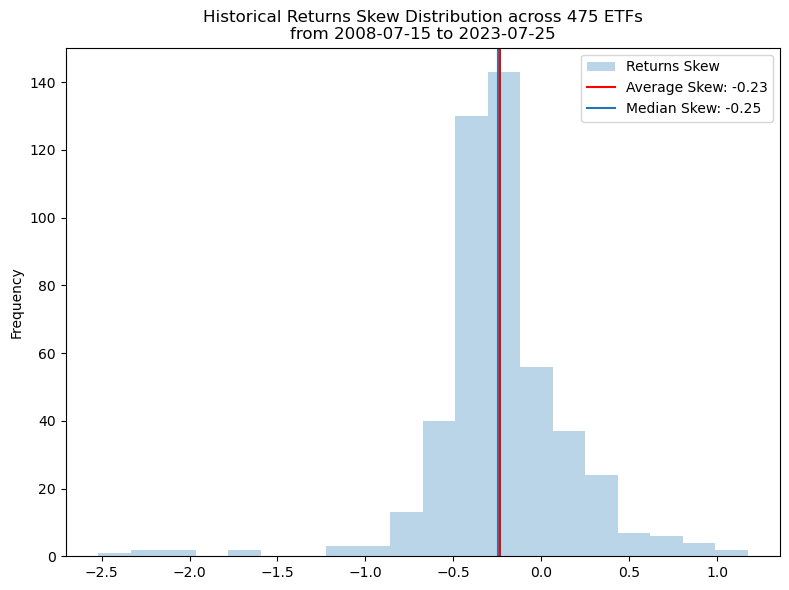

In [15]:
fig, axes = plt.subplots(figsize = (8, 6))

average_skew = df_skew_drop.skew_value.mean()
median_skew = df_skew_drop.skew_value.median()

(df_skew_drop[
    ["skew_value"]].
    rename(columns = {"skew_value": "Returns Skew"}).
    plot(
        kind = "hist", 
        bins = 20,
        legend = False,
        ax = axes,
        alpha = 0.3,
        xlabel = "Daily Returns Skew",
        title = "Historical Returns Skew Distribution across {} ETFs\nfrom {} to {}".format(
            len(df_skew_drop),
            df_returns.index.min().date(),
            df_returns.index.max().date())))

axes.axvline(
    average_skew, 
    color = "r", 
    label =  "Average Skew: {}".format(round(average_skew, 2)))

axes.axvline(
    median_skew,
    label = "Median Skew: {}".format(round(median_skew, 2)))

axes.legend()
plt.tight_layout()
plt.show()

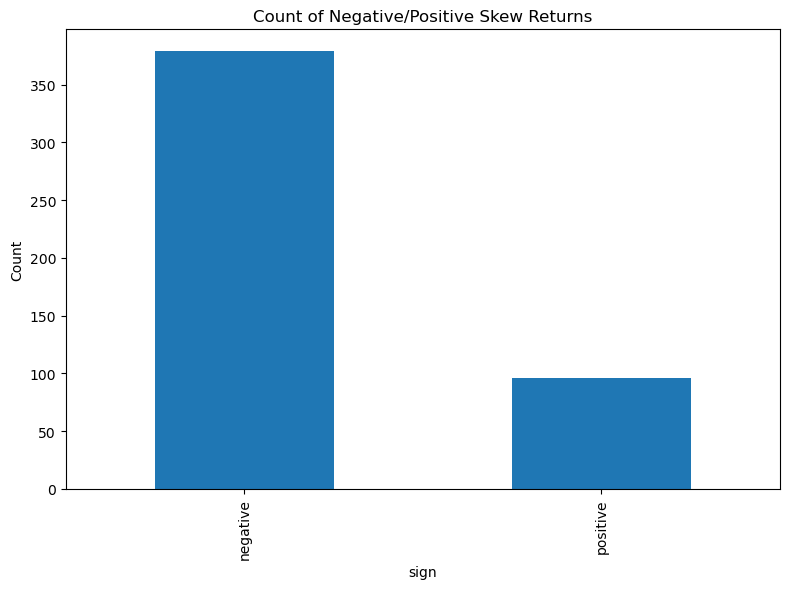

In [16]:
df_skew_count = (df_skew_drop.assign(
    sign = lambda x: np.sign(x.skew_value))
    [["sign", "skew_value"]].
    groupby("sign").
    agg("count").
    reset_index().
    merge(pd.DataFrame({
        "sign": [-1, 1],
        "sign_": ["negative", "positive"]}),
         how = "inner",
         on = ["sign"]).
    drop(columns = ["sign"]).
    rename(columns = {
        "sign_": "sign",
        "skew_value": "count"}).
    set_index("sign"))

(df_skew_count.plot(
    kind = "bar", 
    legend = False,
    ylabel = "Count",
    figsize = (8,6),
    title = "Count of Negative/Positive Skew Returns"))

plt.tight_layout()
plt.show()

# Calculate and Plot Cumulative Returns

In [17]:
def _cum_rtn(df: pd.DataFrame) -> pd.DataFrame: return(df.assign(cum_rtn = lambda x: np.cumprod(1 + x.value) - 1))

df_cum_rtn = (df_returns.reset_index().melt(
    id_vars = "Date").
    query("variable == @good_tickers").
    groupby("variable").
    apply(_cum_rtn))

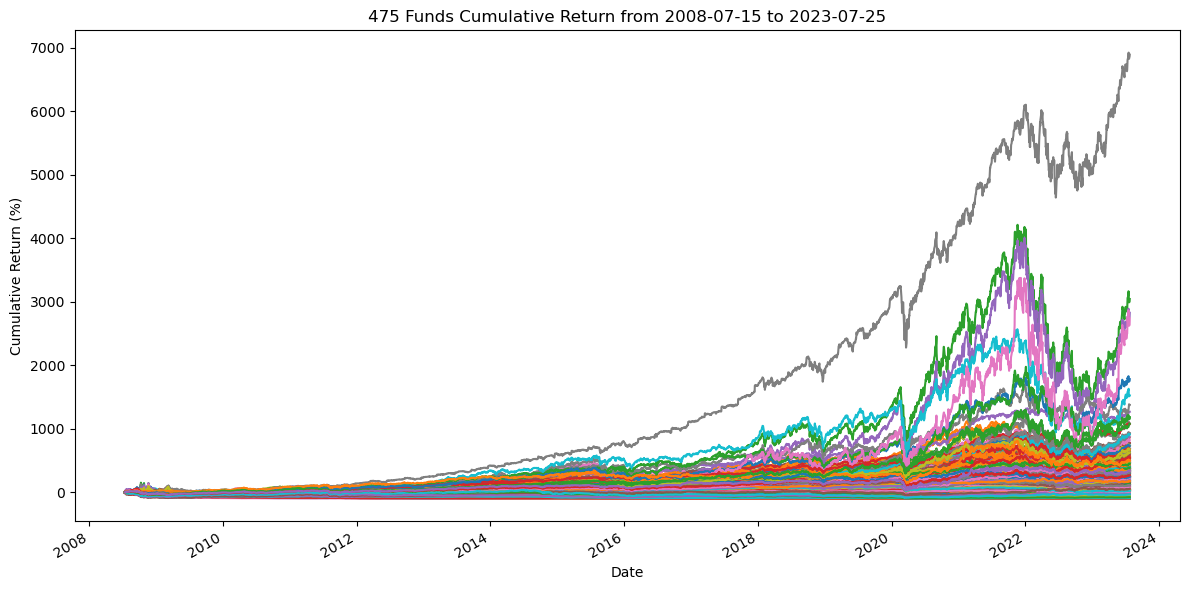

In [18]:
df_cum_wider = ((df_cum_rtn.drop(
    columns = ["value"]).
    pivot(index = "Date", columns = "variable", values = "cum_rtn")
    * 100))

(df_cum_wider.plot(
    legend = False,
    figsize = (12, 6),
    ylabel = "Cumulative Return (%)",
    title = "{} Funds Cumulative Return from {} to {}".format(
        len(df_cum_wider.columns),
        df_cum_wider.index.min().date(),
        df_cum_wider.index.max().date())))

plt.tight_layout()

Some of them look wrong let's drop them via z-score

In [19]:
rtn_good_tickers = (df_cum_wider.reset_index().melt(
    id_vars = "Date").
    query("Date == Date.max()").
    assign(z_score = lambda x: np.abs((x.value - x.value.mean()) / x.value.std())).
    query("z_score < 2")
    ["variable"].
    to_list())

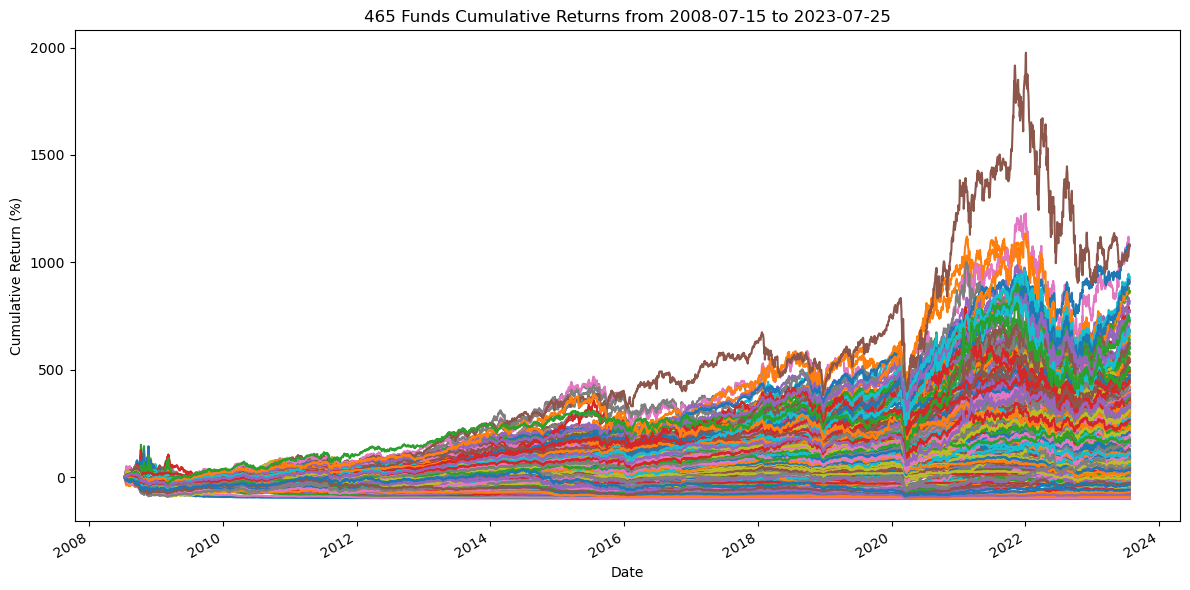

In [20]:
df_cum_plot = (df_cum_rtn.query(
    "variable == @rtn_good_tickers").
    drop(columns = ["value"]).
    pivot(index = "Date", columns = "variable", values = "cum_rtn") 
    * 100)

(df_cum_plot.plot(
    legend = False,
    ylabel = "Cumulative Return (%)",
    figsize = (12, 6),
    title = "{} Funds Cumulative Returns from {} to {}".format(
        len(df_cum_plot.columns),
        df_cum_plot.index.min().date(),
        df_cum_plot.index.max().date())))

plt.tight_layout()
plt.show()

# Drawdown Function

In [94]:
def mdd(prices: list):
    
    maxDif = 0
    start = prices[0]
    for i in range(len(prices)):
        maxDif = min(maxDif, prices[i]-start)
        start = max(prices[i], start)
    return maxDif

In [103]:
def _drawdown(df, verbose = False):
    
    if verbose == True: print("Working on", df.variable.iloc[0])
    rtns = df["value"]
    drawdown_amount = mdd(rtns.to_list())
    return(pd.DataFrame({
        "drawdown": [drawdown_amount]}))
    
df_drawdown = (df_cum_plot.reset_index().melt(
    id_vars = "Date").
    groupby("variable").
    apply(_drawdown))

In [116]:
df_drawdown_z = (df_drawdown.assign(
    z_score = lambda x: np.abs((x.drawdown - x.drawdown.mean()) / x.drawdown.std())).
    query("z_score < 2"))

In [138]:
df_skew_drawdown = (df_drawdown_z.reset_index().merge(
    df_skew_drop.reset_index(),
    how = "inner",
    on = ["variable"]))

In [164]:
regression = (sm.OLS(
    endog = df_skew_drawdown.drawdown,
    exog = sm.add_constant(df_skew_drawdown.skew_value)).
    fit())

alpha, beta = regression.params
rsquared = regression.rsquared

x = np.linspace(start = df_skew_drawdown.skew_value.min(), stop = df_skew_drawdown.skew_value.max(), num = 1_000)
y = (x * beta) + alpha

In [193]:
df_skew_count = (df_skew_drawdown[
    ["skew_value"]].
    assign(sign = lambda x: np.sign(x.skew_value)).
    groupby("sign").
    agg("count").
    reset_index().
    assign(count = lambda x: np.where(x.sign == -1.0, "Negative\n Skew", "Positive\n Skew")))

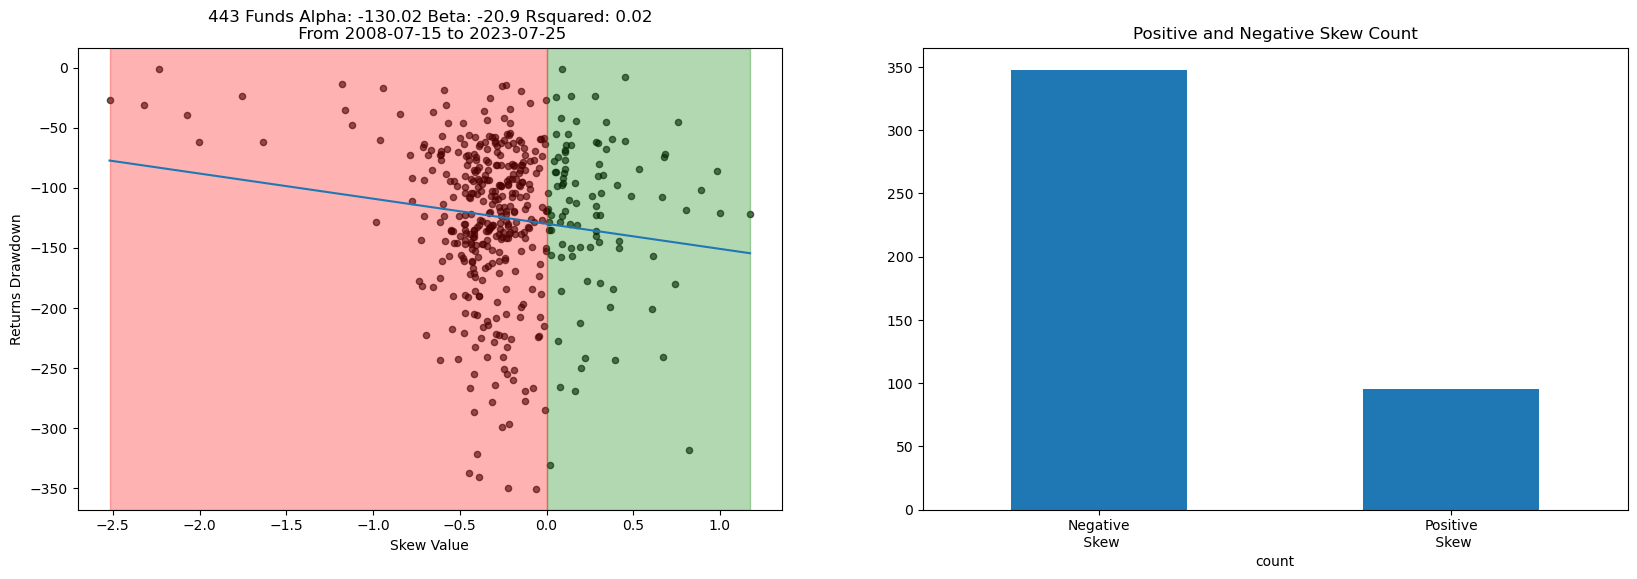

In [194]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))

(df_skew_drawdown.plot(
    kind = "scatter", x = "skew_value", y = "drawdown",
    ax = axes[0],
    ylabel = "Returns Drawdown",
    xlabel = "Skew Value",
    color = "black",
    alpha = 0.6,
    title = "{} Funds Alpha: {} Beta: {} Rsquared: {}\n From {} to {}".format(
        len(df_skew_drawdown.variable.to_list()),
        round(alpha, 2),
        round(beta, 2),
        round(rsquared, 2),
        df_cum_plot.index.min().date(),
        df_cum_plot.index.max().date())))

(df_skew_count.set_index(
    "count")
    [["skew_value"]].
    plot(
        kind = "bar", ax = axes[1],
        legend = False,
        title = "Positive and Negative Skew Count"))

axes[0].plot(x, y)
axes[0].axvspan(0, df_skew_drawdown.skew_value.max(), color = "green", alpha = 0.3)
axes[0].axvspan(df_skew_drawdown.skew_value.min(), 0, color = "red", alpha = 0.3)
axes[1].tick_params(axis='x', rotation = 360)
